### Exploring Young People's income

This is a short notebook to explore different sources of data on young people's income. In particular, we are interested in how it has evolved in recent years and how its level and growth compare to the income of other age cohorts. We want to pay particular attention to the definition of income.

In [14]:
# import packages
import pandas as pd
import numpy as np
import os
from IPython.display import Image
import requests
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from cycler import cycler
import io
from zipfile import ZipFile

In [15]:
# set some preliminaries
mpl.rcParams['font.family'] = 'Gill Sans MT'
rsa_colour_dict = {'black':'#000000',
                   'teal':'#03ECDD',
                   'half-teal':(129.5/256, 246/256, 238.5/256),
                   'light grey':'#F5F5F5',
                   'mid grey':'#969696', 
                   'dark grey':'#373737',
                   'dark blue':'#000C78', 
                   'light blue':'#21DCFF',
                   'half-light blue':(144.5/256, 243/256, 255.5/256),
                   'hot pink':'#FF21B8', 
                   'orange':'#FFA72F',
                   'red':'#FF2800',
                   'forestgreen':'forestgreen',
                   'violet':'violet',
                   'olive':'olive',
                   'darkturquoise':'darkturquoise'}
colour_list = [rsa_colour_dict[x] for x in ['black', 'teal', 'dark blue', 'hot pink', 'dark grey', 'light blue', 'mid grey', 'orange', 'red', 'forestgreen', 'violet', 'olive', 'darkturquoise']]
mpl.rcParams['axes.prop_cycle'] = cycler(color=colour_list)

### Defining income

#### Original vs gross vs disposable income

The below graphic shows some of the main definitions of income used by the ONS. The graphic is taken from a publication on household income, but it applies equally to individual income.

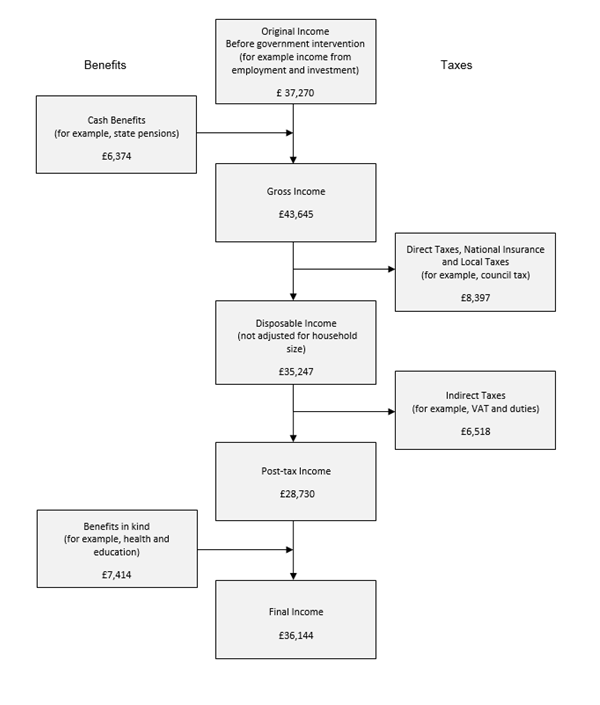

In [16]:
url = 'https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/personalandhouseholdfinances/incomeandwealth/bulletins/theeffectsoftaxesandbenefitsonhouseholdincome/financialyearending2017/4a497a9a.png'
filename = url.split('/')[-1]
filepath = os.path.join('..','data', filename)
if os.path.isfile(filepath) == False:
    req = requests.get(url)
    with open(filepath, 'wb') as output_file:
        output_file.write(req.content)
Image(filepath)

#### Households vs individuals

Data from the ONS' household surveys can often be broken down by household characteristics. In the case of age, this generally refers to the age of the 'household reference person', which is defined as follows:

"The household reference person is the person with the main responsibility for the property, for example, the person who owns the property, or who is legally responsible for the rent. If this is joint, the household reference person is the person with the highest income. If the income is the same, then the eldest person is selected." [(ref.)](https://www.ons.gov.uk/peoplepopulationandcommunity/personalandhouseholdfinances/incomeandwealth/articles/generationalincometheeffectsoftaxesandbenefits/2019-08-21)

If we combine this information with the distribution of young people living with their parents by age, we can see that recent household data for the 18-24 year old age group captures at most 41% of 18-24 year olds. In practice, some 18-24 year olds probably live in households in which the household reference person is older (i.e. a 24yr old living with a 25yr old and sharing responsibility for bills would show up in the 25-X category. Two complications flow from this:
- the subsample of 18-24yr olds living on their own is almost certainly not representative of the broader population;
- the proportion living independently has fallen over time, making it hard to compare household income for the 18-24yr old category over time.

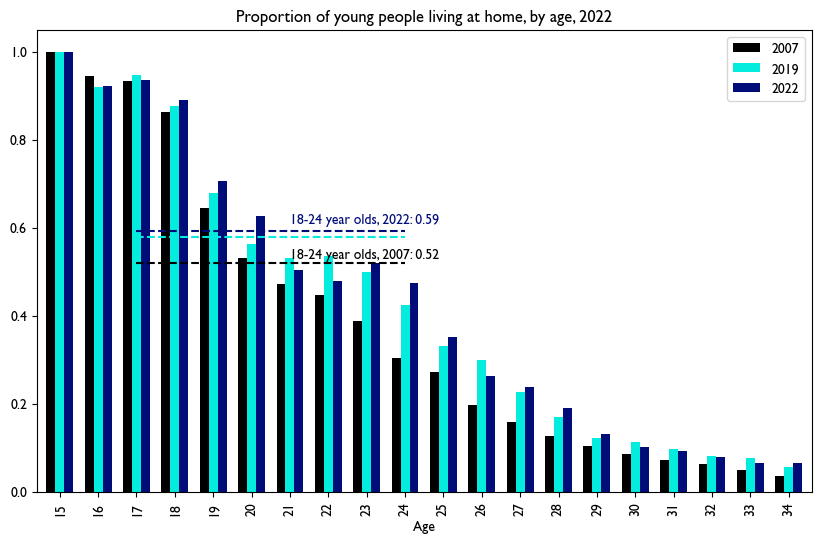

In [17]:
### Households vs individuals

# get data for 2022
url = 'https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/families/datasets/youngadultslivingwiththeirparents/current/youngadults20221.xlsx'
filename = url.split('/')[-1]
filepath = os.path.join('..','data', filename)
if os.path.isfile(filepath) == False:
    req = requests.get(url)
    with open(filepath, 'wb') as output_file:
        output_file.write(req.content)
xl = pd.ExcelFile(filepath, engine='openpyxl')
athome22 = xl.parse(sheet_name='2022', skiprows=11, usecols=[0,3,10], nrows=20)
athome22.columns = ['Age', 'People', 'Living with parents']
athome22 = athome22.set_index('Age')

# get data for 1996-2019
url = 'https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/families/datasets/youngadultslivingwiththeirparents/current/previous/v5/youngadults19962019final.xls'
filename = url.split('/')[-1]
filepath = os.path.join('..','data', filename)
if os.path.isfile(filepath) == False:
    req = requests.get(url)
    with open(filepath, 'wb') as output_file:
        output_file.write(req.content)
xl = pd.ExcelFile(filepath)
athome19 = xl.parse('1996-2019', skiprows=189, usecols='A,AJ,AQ', nrows=20,header=None)
athome19.columns = ['Age', 'People', 'Living with parents']
athome19 = athome19.set_index('Age')
athome07 = xl.parse('1996-2019', skiprows=85, usecols='A,AJ,AQ', nrows=20,header=None)
athome07.columns = ['Age', 'People', 'Living with parents']
athome07 = athome07.set_index('Age')

# combine it
athome_pc = pd.concat([df['Living with parents'].div(df['People']) for df in [athome07, athome19, athome22]], axis=1)
athome_pc.columns = [2007, 2019, 2022]

pc_18_24_2022 = athome22.loc[18:24, 'Living with parents'].sum() /  athome22.loc[18:24, 'People'].sum()
pc_18_24_2019 = athome19.loc[18:24, 'Living with parents'].sum() /  athome19.loc[18:24, 'People'].sum()
pc_18_24_2007 = athome07.loc[18:24, 'Living with parents'].sum() /  athome07.loc[18:24, 'People'].sum()

fig, ax = plt.subplots(1,1,figsize=[10,6])
athome_pc.plot(ax=ax, kind='bar', width=0.7)
ax.plot([2,9],[pc_18_24_2022, pc_18_24_2022], color=colour_list[2], linestyle='dashed')
ax.plot([2,9],[pc_18_24_2019, pc_18_24_2019], color=colour_list[1], linestyle='dashed')
ax.plot([2,9],[pc_18_24_2007, pc_18_24_2007], color=colour_list[0], linestyle='dashed')
ax.set_title('Proportion of young people living at home, by age, 2022')
ax.text(x=6,y=0.61,s='18-24 year olds, 2022: {:.2f}'.format(pc_18_24_2022), color=colour_list[2]);
ax.text(x=6,y=0.53,s='18-24 year olds, 2007: {:.2f}'.format(pc_18_24_2007), color=colour_list[0]);

#### Nominal vs real income

When comparing income over time, it is common to look at 'real' income - that is, income that has been adjusted for inflation. The idea is to make income more comparable over time in terms of the goods and services it can buy. If we're going to use real income, it is helpful to think about the inflation series that is used to deflate nominal income and whether that series is appropriate for young people (i.e. whether it is a basket of things young people buy and if not, whether this is important to our anlaysis).

### Data currently used in the text

The text currently uses data on the equivalised, real disposable income of households by age group to make points about both the level and growth rate of young households' income relative to older households (data below).

**Levels**

I don't think this makes sense as a comparison of levels across age groups, because the 18-24 age group is likely biased towards people most able to leave the family home. It would make more sense to use a data source that looks at individual income to compare income across age groups.

**Growth rates**

I don't think it makes sense for growth rates either, as the declining percentage of young people living outside the parental home increases any bias towards wealthier young people over time. Furthermore, the statistics quoted seem pretty arbitrary.

In [18]:
### Data currently used in the text

url = 'https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/personalandhouseholdfinances/incomeandwealth/datasets/householddisposableincomeandinequality/financialyearending2022/hdiifye2022correction2.xlsx'
filename = url.split('/')[-1]
filepath = os.path.join('..','data', filename)
if os.path.isfile(filepath) == False:
    req = requests.get(url)
    with open(filepath, 'wb') as output_file:
        output_file.write(req.content)
xl = pd.ExcelFile(filepath, engine='openpyxl')
tab7 = xl.parse(sheet_name='Table 7', skiprows=3, header=[0,1], nrows=20, index_col=0)

In [19]:
tab7

0-17         18-24        25 to 34        35 to 44        45 to 54  \
Year      Mean Median   Mean Median     Mean Median     Mean Median     Mean   
2001/02  29049  23600  30805  28260    38313  32203    37385  29836    38588   
2002/03  29931  23817  30413  28858    39487  33367    38076  31257    39448   
2003/04  30545  25526  31581  28710    39668  32293    38426  30508    39690   
2004/05  31799  25906  33019  29953    40275  33684    40808  31426    42565   
2005/06  32708  25959  32764  29134    39542  34675    42716  32605    42194   
2006/07  34626  25897  31495  27587    41977  36371    40848  32737    44056   
2007/08  38314  26445  31130  27676    40928  36425    47400  33067    41350   
2008/09  33289  25750  30939  28676    39930  34471    45654  32694    41538   
2009/10  33995  26258  34402  28075    39004  35083    44346  33239    44247   
2010/11  34049  26505  30871  26924    38773  34358    40592  32421    42272   
2011/12  32226  26036  28121  25256    39221  32754    38435  31757    39466   
2012/13  31955  25216  27859  24377    36736  31839    38327  30343    39619   
2013/14  33688  25553  30276  25626    39786  32117    40439  32089    38790   
2014/15  34705  26590  30600  28137    40654  33297    40975  32589    40673   
2015/16  35869  26775  31877  26756    39079  33672    39651  32382    44733   
2016/17  32922  26569  34429  29638    39225  35270    40152  33995    47477   
2017/18  34378  26795  33647  29123    38755  34103    41356  33178    42714   
2018/19  34283  26657  33379  28167    38655  34544    42106  34020    43112   
2019/20  35928  28380  35911  31164    41796  37291    45097  35866    45402   
2020/21  34364  28726  36113  32261    43053  37773    44519  36246    41863   

               55 to 64        65 to 74        75 to 84           85+         
Year    Median     Mean Median     Mean Median     Mean Median   Mean Median  
2001/02  32555    32615  25761    26310  20271    21173  17482  22672  17690  
2002/03  33542    35352  28296    26301  21407    23751  19301  23013  19763  
2003/04  34357    35137  29221    27890  22860    22768  18861  23757  20839  
2004/05  35681    35196  30006    28450  23154    24181  20946  27529  20005  
2005/06  36091    40297  30524    29833  23054    27184  20745  23564  22093  
2006/07  35962    41642  31227    31337  23440    25351  21250  22953  20588  
2007/08  33949    41268  31762    31007  23712    25831  22285  26708  22070  
2008/09  34915    37792  30834    28697  24507    24874  21330  23195  21860  
2009/10  34754    41061  31259    31460  25257    26746  22751  25132  22413  
2010/11  34582    37427  30231    30368  25258    30558  23637  27816  23693  
2011/12  32650    41297  31499    32405  25778    27727  23372  26756  24180  
2012/13  32003    38026  30435    33781  26740    27349  23066  29196  22779  
2013/14  32444    38820  30619    35121  28045    28636  24741  27282  24962  
2014/15  33831    38073  32165    34392  27586    31263  24968  28934  22446  
2015/16  34903    42123  33144    35800  28172    32479  25230  27690  25931  
2016/17  35890    40666  34834    36538  30489    31040  25022  27147  23788  
2017/18  34483    38314  31994    36784  29309    29983  25623  29592  24004  
2018/19  34020    39746  32459    38215  31127    30660  25462  26277  22992  
2019/20  36880    39736  33686    37261  29505    28969  24980  27368  23846  
2020/21  36254    42190  33756    36969  30567    32013  27143  29555  25429

#### Using data on individual incomes instead

**Levels**

If we use data from the Annual Survey of Hours and Earnings, I think we can make a better point about the levels differences between the pay of young people and older cohorts. Importantly, we can also use this to show how reliant the lower end of the distribution is on support from others, particularly for 18-21 year olds.

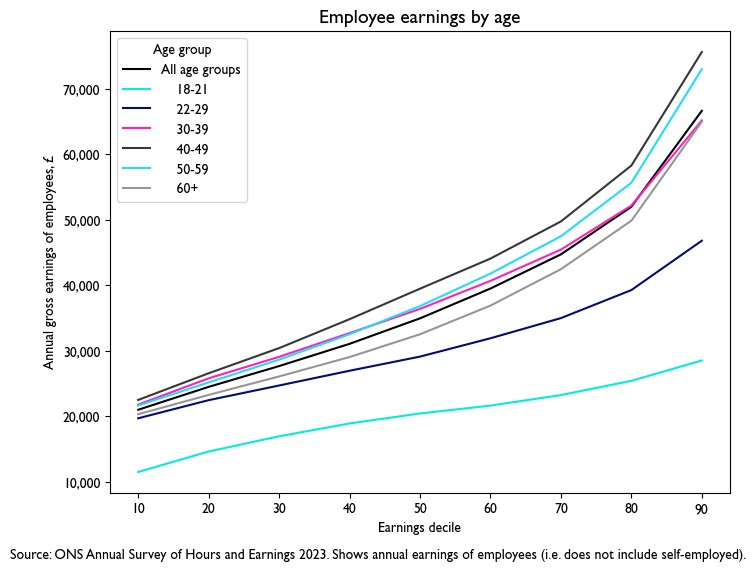

In [20]:
#### Using data on individual incomes instead

url = 'https://www.ons.gov.uk/file?uri=/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/agegroupashetable6/2023provisional/ashetable62023provisional.zip'
req = requests.get(url)
filename = url.split('/')[-1]
filepath = os.path.join('..', 'data', filename)
if os.path.isfile(filepath) == False:
    with open(filepath, 'wb') as output_file:
        output_file.write(req.content)
# get the gross weekly pay spreadsheet and select the 'All' tab, then tidy up column names manually
xl = pd.ExcelFile(io.BytesIO(
    ZipFile(filepath).read('PROV - Age Group Table 6.7a   Annual pay - Gross 2023.xls')))
ashe = xl.parse(sheet_name='Full-Time', skiprows=4, nrows=8, usecols='A:Q', na_values=['x'])
ashe = ashe.rename({'Median':'50'}, axis=1)
# change 'description' to 'age group'
ashe = ashe.rename(columns={'Description':'Age group'})
ashe.set_index('Age group', inplace=True)
# change 'all employees' to 'all age groups'
ashe = ashe.rename(index={'All employees': 'All age groups'})
ashe = ashe.loc[:,[str(x) for x in range(10,100,10)]].dropna(axis=0)
fig, ax = plt.subplots(1,1,figsize=[8,6])
ashe.transpose().plot(ax=ax)

def format_tick_labels(x, pos):
    return '{:,.0f}'.format(x)
ax.yaxis.set_major_formatter(FuncFormatter(format_tick_labels))

ax.set_title('Employee earnings by age', fontsize=14)
ax.set_xlabel('Earnings decile')
ax.set_ylabel('Annual gross earnings of employees, £')
fig.text(x=0,y=0,s='Source: ONS Annual Survey of Hours and Earnings 2023. Shows annual earnings of employees (i.e. does not include self-employed).');

In [22]:
# Get the ASHE data for a few earlier points in time
url = 'https://www.ons.gov.uk/file?uri=/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/agegroupashetable6/2019revised/table62019revised.zip'
req = requests.get(url)
filename = url.split('/')[-1]
filepath = os.path.join('..', 'data', filename)
if os.path.isfile(filepath) == False:
    with open(filepath, 'wb') as output_file:
        output_file.write(req.content)
# get the gross weekly pay spreadsheet and select the 'All' tab, then tidy up column names manually
xl = pd.ExcelFile(io.BytesIO(
    ZipFile(filepath).read('Age Group Table 6.7a   Annual pay - Gross 2019.xls')))
ashe19 = xl.parse(sheet_name='Full-Time', skiprows=4, nrows=8, usecols='A:Q', na_values=['x'])
ashe19 = ashe19.rename({'Median':50}, axis=1)
ashe19.set_index('Description', inplace=True)
ashe19 = ashe19.loc[:,[x for x in range(10,100,10)]].dropna(axis=0)

url = 'https://www.ons.gov.uk/file?uri=/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/agegroupashetable6/2019revised/table62019revised.zip'
req = requests.get(url)
filename = url.split('/')[-1]
filepath = os.path.join('..', 'data', filename)
if os.path.isfile(filepath) == False:
    with open(filepath, 'wb') as output_file:
        output_file.write(req.content)
# get the gross weekly pay spreadsheet and select the 'All' tab, then tidy up column names manually
xl = pd.ExcelFile(io.BytesIO(
    ZipFile(filepath).read('Age Group Table 6.7a   Annual pay - Gross 2019.xls')))
ashe19 = xl.parse(sheet_name='Full-Time', skiprows=4, nrows=8, usecols='A:Q', na_values=['x'])
ashe19 = ashe19.rename({'Median':50}, axis=1)
ashe19.set_index('Description', inplace=True)
ashe19 = ashe19.loc[:,[x for x in range(10,100,10)]].dropna(axis=0)
ashe19.columns = [str(x) for x in ashe19.columns]

url = 'https://www.ons.gov.uk/file?uri=/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/agegroupashetable6/2008/2008-table-6.zip'
req = requests.get(url)
filename = url.split('/')[-1]
filepath = os.path.join('..', 'data', filename)
if os.path.isfile(filepath) == False:
    with open(filepath, 'wb') as output_file:
        output_file.write(req.content)
# get the gross weekly pay spreadsheet and select the 'All' tab, then tidy up column names manually
xl = pd.ExcelFile(io.BytesIO(
    ZipFile(filepath).read('Age Group Table 6.7a   Annual pay - Gross 2008.xls')))
ashe08 = xl.parse(sheet_name='Full-Time', skiprows=4, nrows=8, usecols='A:Q', na_values=['x'])
ashe08 = ashe08.rename({'Median':50}, axis=1)
ashe08.set_index('Description', inplace=True)
ashe08 = ashe08.loc[:,[x for x in range(10,100,10)]].dropna(axis=0)
ashe08.columns = [str(x) for x in ashe08.columns]

**Growth rates**

It's a bit of a pain to look at time series of the ASHE data by age, but taking snapshots from 2008, 2019 and 2023, there are some interesting patterns. Median wage growth for young people has been relatively high. But wage growth for 18-21 year olds in lower wage occupations has been noticeably weak. This mighst be worth bringing out in the report.

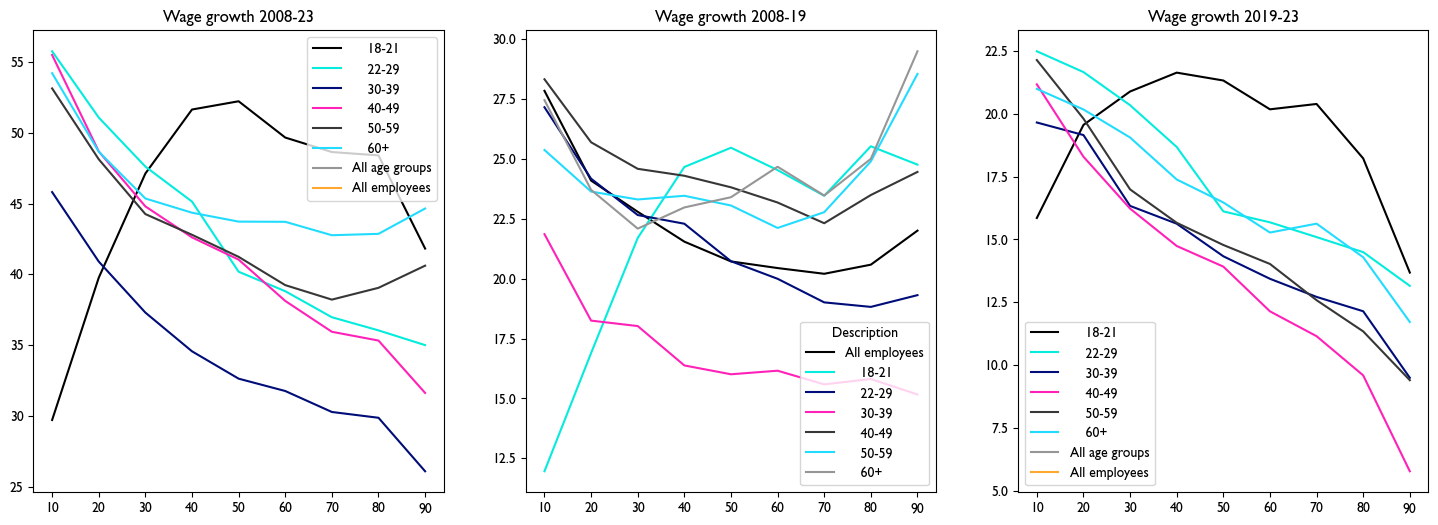

In [23]:
fig, [ax, ax2, ax1] = plt.subplots(1,3,figsize=[18,6])
(ashe.div(ashe08, axis=0).transpose()).apply(lambda x: 100*(x-1)).plot(ax=ax)
ax.set_title('Wage growth 2008-23')

(ashe.div(ashe19, axis=0).transpose()).apply(lambda x: 100*(x-1)).plot(ax=ax1)
ax1.set_title('Wage growth 2019-23')

(ashe19.div(ashe08, axis=0).transpose()).apply(lambda x: 100*(x-1)).plot(ax=ax2)
ax2.set_title('Wage growth 2008-19');